### LightGBM с учетом праздников

Визуализация продаж по неделям показала, что вблизи праздничных дат часто присутствуют локальные пики.

**Гипотеза**: если сообщить LighGBM, какой сейчас праздник +-1 неделя, это даст серьезный прирост точности.

In [20]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
os.chdir("D:/demo/ML/demo_dominicks")

from src.utils import get_holidays, get_holiday_names, prepare_training_data
_in_df = pd.read_csv('data/baseline_dataset.csv', index_col=0)

In [51]:
baseline_df = _in_df.copy()
baseline_df.dropna()
baseline_df.drop(baseline_df[baseline_df.price < 0.01].index, inplace=True)
baseline_df['revenue'] = baseline_df['move'] * baseline_df['price']
baseline_df.drop(columns='move', inplace=True)
baseline_df.head()

,com_code,upc,descrip,size,store,week,price,sale,age60,age9,...,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5,revenue
1,953,1192603016,CAFFEDRINE CAPLETS 1,16 CT,76,307,2.99,N,0.149192,0.141775,...,0.425324,10.140613,0.144374,0.296353,0.096330,3.558380,0.909091,1.075632,0.214417,2.99
66,953,1192662108,SLEEPINAL SOFTGEL,8 CT,71,286,4.49,N,0.268071,0.111724,...,0.074828,10.404839,0.075014,0.303102,0.163882,6.673880,1.450000,1.818359,0.266474,4.49
152,953,1192662108,SLEEPINAL SOFTGEL,8 CT,98,286,4.49,N,0.249201,0.118516,...,0.164964,10.573596,0.125409,0.299584,0.009843,6.230357,1.500000,3.133177,0.381569,8.98
240,953,1192662108,SLEEPINAL SOFTGEL,8 CT,101,288,4.49,N,0.225035,0.116925,...,0.087422,10.659938,0.096042,0.390065,0.354574,4.849623,0.500000,2.200318,0.342081,4.49
324,953,1192662108,SLEEPINAL SOFTGEL,8 CT,121,286,4.49,N,0.163581,0.131251,...,0.039174,10.949929,0.091694,0.382304,0.610862,3.751225,1.090909,2.069346,0.559534,8.98


In [52]:
holidays = get_holidays()
for h_name in get_holiday_names():
    baseline_df[f"before_{h_name}"] = baseline_df.week.isin(np.array(holidays[h_name])-1).astype(int).astype('category')
    baseline_df[h_name] = baseline_df.week.isin(np.array(holidays[h_name])).astype(int).astype('category')
    baseline_df[f"after_{h_name}"] = baseline_df.week.isin(np.array(holidays[h_name])+1).astype(int).astype('category')


In [53]:
baseline_df.loc[:, 'size_cat'] = baseline_df['size'].astype('category').cat.codes.astype(int)
baseline_df.loc[:, 'descrip_cat'] = baseline_df['descrip'].astype('category').cat.codes.astype(int)
baseline_df.loc[:, 'sale_cat'] = baseline_df['sale'].astype('category').cat.codes.astype(int)

In [ ]:
baseline_df.sample(5)

,com_code,upc,descrip,size,store,week,price,sale,age60,age9,...,after_mem_day,before_indep_day,indep_day,after_indep_day,before_labor_day,labor_day,after_labor_day,size_cat,descrip_cat,sale_cat
6281714,953,31981007172,BUFFERIN X/S TABS,50 CT,117,194,7.59,N,0.110103,0.139094,...,0,0,0,0,0,0,0,55,118,3
7047051,953,35310018624,VIVARIN STIMULANT TA,16 CT,54,66,2.49,N,0.090222,0.147915,...,0,0,0,0,0,0,0,19,408,3
6978508,953,35310012822,SOMINEX 2(DIPHEHHYDR,16 CT,112,52,3.43,N,0.089724,0.163612,...,0,0,0,0,0,0,1,19,328,3
1798835,953,30045044907,TYLENOL X/S CAPLET,50 CT,111,172,5.39,N,0.210513,0.145874,...,0,0,0,0,0,0,0,55,384,3
6005072,953,31981000892,EXCEDRIN ASPIRIN-FRE,50 CT,54,258,7.69,N,0.090222,0.147915,...,0,0,0,0,0,0,0,55,194,3


In [62]:
X_train, X_test, y_train, y_test = prepare_training_data(baseline_df, 
                cat_cols=['descrip_cat', 'size_cat', 'sale_cat'],
                cols2drop=['com_code', 'upc', 'store', 'size', 'descrip', 'sale', 'week'],
                target_cols=['revenue'])

cat_features : 3 ['descrip_cat', 'size_cat', 'sale_cat']
num_features : 40 ['price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge', 'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5', 'before_halloween', 'halloween', 'after_halloween', 'before_thanksgiving', 'thanksgiving', 'after_thanksgiving', 'before_christmas', 'christmas', 'after_christmas', 'before_newyear', 'newyear', 'after_newyear', 'before_pres_day', 'pres_day', 'after_pres_day', 'before_easter', 'easter', 'after_easter', 'before_mem_day', 'mem_day', 'after_mem_day', 'before_indep_day', 'indep_day', 'after_indep_day', 'before_labor_day', 'labor_day', 'after_labor_day']
targets ['revenue']


In [63]:
_str = baseline_df.columns[21:48].to_list()
cat_names = "name:" + ','.join(str(x) for x in _str)
cat_names

'name:before_halloween,halloween,after_halloween,before_thanksgiving,thanksgiving,after_thanksgiving,before_christmas,christmas,after_christmas,before_newyear,newyear,after_newyear,before_pres_day,pres_day,after_pres_day,before_easter,easter,after_easter,before_mem_day,mem_day,after_mem_day,before_indep_day,indep_day,after_indep_day,before_labor_day,labor_day,after_labor_day'

In [64]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_names)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=cat_names)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["l2"],
    "max_bin": 2048,
    "num_leaves": 2048,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "num_iterations": 1000,
    "num_threads": 24
}
'''
model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='mae',
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=50, show_stdv=True)
            ]
        )
'''
gbm = lgb.train(
    params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=50, show_stdv=True)
            ]
)

d:\applications\miniconda3\envs\torch\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[50]	valid_0's l2: 90.8985
[100]	valid_0's l2: 88.1878
[150]	valid_0's l2: 87.9895
[200]	valid_0's l2: 88.1866
[250]	valid_0's l2: 88.6549
[300]	valid_0's l2: 88.8366
Early stopping, best iteration is:
[146]	valid_0's l2: 87.9554


In [65]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print(f'\n Accuracy: {mean_squared_error(y_test, y_pred)}')
#print(f'\n Accuracy: {accuracy_score(y_test, y_pred.astype(int))}')


 Accuracy: 87.95539598236492


In [60]:
y_test[:20]

,revenue
2607310,10.59
2170252,7.69
1671005,2.99
1437357,3.99
421012,13.77
586670,6.98
1409573,8.29
6747580,8.69
1795322,78.24
6450958,8.38


In [61]:
y_pred[:20]

array([17.1460055 , 47.30368769,  5.31088077,  8.46932508,  8.23750283,
        7.69328338, 15.94150668, 10.75498811, 56.97711376,  7.68241914,
        9.28059996, 10.43764097, 23.54292525, 11.42178868,  3.3786955 ,
       13.06448016, 10.58420627, 11.81801179,  8.94488177, 12.55788802])

In [76]:
gbm.save_model('model/03-holiday-model.txt', num_iteration=gbm.best_iteration)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

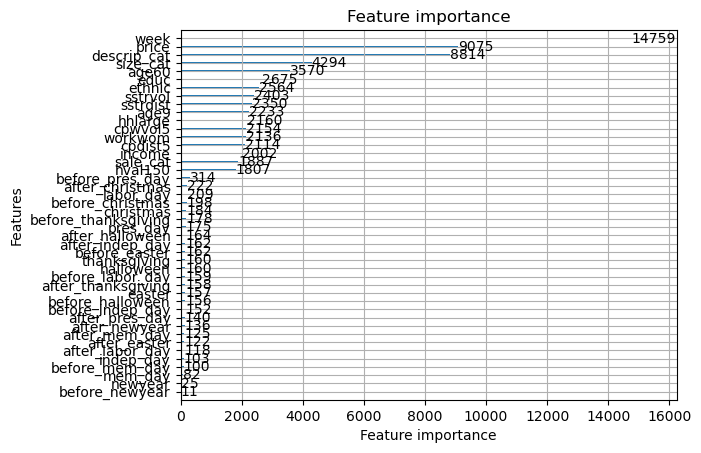

In [77]:
lgb.plot_importance(gbm)